
#**Métaheuristique (Evolutionaire) pour Coloration du Graphe**
#### 1. **Membres de l'équipe :**
  - Aoulmi Lina
  - Hamadene Kamelia
  - Laouzai Lina
  - Amoura Yousra
  - Ouadi Amina Tinhinene
  - Ouikene Youcef

#### 2. **Introduction :**

Les algorithmes évolutionnaires (AE) font partie des métaheuristiques, c’est-à-dire des méthodes génériques capables de s’adapter à une grande variété de problèmes sans nécessiter une modélisation mathématique explicite.

Ils utilisent une population de solutions candidate, évoluant au fil des générations par le biais d’opérations inspirées de la nature, telles que la sélection, le croisement (recombinaison) et la mutation. Leur objectif est de faire émerger, par une évolution guidée, une solution optimale ou quasi-optimale.

Parmi les algorithmes évolutionnaires les plus connus, on trouve :


1.   **Algorithme Colonie de fourmis (ACO)**
2.   **Algorithme génétique  (AG)**





# **1. Initialisation de Graph**

In [ ]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import os

In [ ]:
import itertools
import pandas as pd

In [ ]:
class Graph:
    def __init__(self):
        self.nodes = set()
        self.edges = defaultdict(set)
        self.adjacency = defaultdict(set)

    def add_edge(self, u, v):
        self.nodes.add(u)
        self.nodes.add(v)
        self.edges[u].add(v)
        self.edges[v].add(u)
        self.adjacency[u].add(v)
        self.adjacency[v].add(u)

    def read_col_file(self, filename):
        with open(filename, 'r') as f:
            for line in f:
                if line.startswith('c'): continue
                elif line.startswith('p'):
                    _, _, num_nodes, num_edges = line.split()
                    self.num_nodes = int(num_nodes)
                    self.num_edges = int(num_edges)
                elif line.startswith('e'):
                    _, u, v = line.split()
                    self.add_edge(int(u), int(v))

    def is_valid_coloring(self, coloring):
        if coloring is None:  # Gestion du cas None
            return False
        for node in self.nodes:
            for neighbor in self.adjacency[node]:
                if coloring.get(node, -1) == coloring.get(neighbor, -1):
                    return False
        return True

    def count_conflicts(self, coloring):
        conflicts = 0
        for node in self.nodes:
            for neighbor in self.adjacency[node]:
                if coloring.get(node, -1) == coloring.get(neighbor, -1):
                    conflicts += 1
        return conflicts // 2  # Chaque conflit est compté deux fois

    def afficher_graphe_colore(self, coloring, k_colors):
        import networkx as nx
        G = nx.Graph()
        for node in self.nodes:
            G.add_node(node)
        for u in self.nodes:
            for v in self.adjacency[u]:
                if u < v:  # éviter les doublons
                    G.add_edge(u, v)

        #colors = plt.colormaps.get_cmap('tab20', k_colors)
        colors = plt.get_cmap('tab20', k_colors)

        node_colors = [colors(coloring.get(node, 0)) for node in G.nodes()]

        pos = nx.spring_layout(G, seed=42)  # disposition stable
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=8)
        plt.title("Coloration du graphe")
        plt.show()



# **2.1. Implementation de l'Algorithme ACO (Ant Colony Optimization.)**


L’ACO (Ant Colony Optimization) est une méthode d’optimisation inspirée du comportement des fourmis. Lorsqu’elles cherchent de la nourriture, les fourmis déposent des phéromones sur les chemins qu’elles empruntent. Plus un chemin est utilisé, plus il est renforcé par les phéromones, attirant d’autres fourmis vers ce chemin prometteur.
En optimisation, ce mécanisme est utilisé pour explorer des solutions possibles à un problème, en favorisant les plus efficaces tout en permettant une certaine exploration aléatoire.



In [ ]:
class ACOGraphColoring:
    def __init__(self, graph, num_ants=10, evaporation_rate=0.1, alpha=1, beta=2, max_iterations=100):
        self.graph = graph
        self.num_ants = num_ants
        self.evaporation_rate = evaporation_rate
        self.alpha = alpha  # Importance des phéromones
        self.beta = beta    # Importance de l'heuristique
        self.max_iterations = max_iterations
        self.best_solution = None
        self.best_conflicts = float('inf')
        self.nodes = sorted(list(self.graph.nodes))

    def initialize_pheromones(self, k_colors):
        # Matrice de phéromones: nodes x colors
        return np.ones((len(self.nodes), k_colors)) * 0.1

    def heuristic_information(self, node, color, partial_coloring):
        # Nombre de voisins déjà colorés avec cette couleur (à minimiser)
        conflicts = 0
        for neighbor in self.graph.adjacency[node]:
            if neighbor in partial_coloring and partial_coloring[neighbor] == color:
                conflicts += 1
        return 1.0 / (1.0 + conflicts)

    def construct_solution(self, pheromones, k_colors):
        solutions = []
        for _ in range(self.num_ants):
            coloring = {}
            for node in self.nodes:
                # Calcul des probabilités pour chaque couleur
                probs = []
                for color in range(k_colors):
                    node_idx = self.nodes.index(node)
                    tau = pheromones[node_idx, color] ** self.alpha
                    eta = self.heuristic_information(node, color, coloring) ** self.beta
                    probs.append(tau * eta)

                # Sélection de la couleur selon les probabilités
                probs = np.array(probs)
                probs /= probs.sum()
                color = np.random.choice(range(k_colors), p=probs)
                coloring[node] = color

            solutions.append(coloring)
        return solutions

    def update_pheromones(self, pheromones, solutions):
        # Évaporation
        pheromones *= (1.0 - self.evaporation_rate)

        # Dépôt de phéromones
        for solution in solutions:
            conflicts = self.graph.count_conflicts(solution)
            if conflicts == 0:
                reward = 1.0
            else:
                reward = 0.5 / conflicts

            for node in self.nodes:
                node_idx = self.nodes.index(node)
                color = solution[node]
                pheromones[node_idx, color] += reward

    def run(self, k_colors):
        pheromones = self.initialize_pheromones(k_colors)
        history = []

        for iteration in range(self.max_iterations):
            # Construction des solutions
            solutions = self.construct_solution(pheromones, k_colors)

            # Évaluation et mise à jour de la meilleure solution
            for solution in solutions:
                conflicts = self.graph.count_conflicts(solution)
                if conflicts < self.best_conflicts:
                    self.best_conflicts = conflicts
                    self.best_solution = solution.copy()
                    if conflicts == 0:
                        break

            history.append(self.best_conflicts)

            # Mise à jour des phéromones
            self.update_pheromones(pheromones, solutions)

            # Arrêt prématuré si solution parfaite trouvée
            if self.best_conflicts == 0:
                break

        return self.best_solution, history

    def find_min_colors(self, min_k=3, max_k=20):
        best_k = None
        best_solution = None

        while min_k <= max_k:
            mid_k = (min_k + max_k) // 2

            solution, _ = self.run(mid_k)
            valid = self.graph.count_conflicts(solution) == 0

            if valid:
                best_k = mid_k
                best_solution = solution
                max_k = mid_k - 1  # Essayer encore plus petit
            else:
                min_k = mid_k + 1  # Augmenter k

        if best_k:
            return best_k, best_solution
        else:
            return None, None  # Aucune solution valide trouvée




# **2.2. Tests ACO**

In [ ]:
def test_parametres_ACO(graph, k_min=5, k_max=8):
    """
    Teste différentes combinaisons de paramètres pour l'algorithme ACO
    et retourne la meilleure configuration trouvée.
    """
    # Définir les plages de paramètres à tester pour l'ACO
    num_ants_list = [20]
    evaporation_rates = [0.1, 0.3]
    alpha_values = [1, 3]
    beta_values = [4]
    max_iterations_list = [ 100]

    # Générer toutes les combinaisons de paramètres
    combinations = list(itertools.product(
        num_ants_list,
        evaporation_rates,
        alpha_values,
        beta_values,
        max_iterations_list
    ))

    resultats = []
    initial_colors = k_max

    print(f"Nombre total de combinaisons à tester : {len(combinations)}\n")

    for idx, (ants, evap, alpha, beta, iters) in enumerate(combinations, 1):

        # Initialiser l'algorithme ACO avec les paramètres actuels
        aco = ACOGraphColoring(
            graph=graph,
            num_ants=ants,
            evaporation_rate=evap,
            alpha=alpha,
            beta=beta,
            max_iterations=iters
        )

        # Mesurer le temps d'exécution
        start_time = time.time()
        min_colors, solution = aco.find_min_colors(min_k=k_min, max_k=k_max)
        elapsed = time.time() - start_time
        # Vérifier si une solution valide a été trouvée
        if solution:
            nb_colors = min_colors
            valid = 1

        else:
            nb_colors = None
            valid = 0

        print(f" [{idx}/{len(combinations)}] : ants={ants}, evap={evap}, alpha={alpha}, beta={beta}, iter={iters} Valid={valid}, Colors={nb_colors}, Time={round(elapsed, 2)}s")

        # Enregistrer les résultats
        resultats.append({
            'Fourmis': ants,
            'Evaporation': evap,
            'Alpha': alpha,
            'Beta': beta,
            'Iterations': iters,
            'Valid': valid,
            'Colors': nb_colors if nb_colors is not None else float('inf'),
            'Time (s)': round(elapsed, 2),
            "solution": solution
        })

    # Analyser les résultats valides
    df = pd.DataFrame(resultats)
    valid_results = df[df['Valid'] == 1]

    if not valid_results.empty:
        # Trier d'abord par nombre de couleurs, puis par temps d'exécution
        best_by_color = valid_results.sort_values(['Colors', 'Time (s)']).iloc[0]
        print("\nMeilleurs paramètres (minimisant les couleurs puis le temps) :")
        print(best_by_color)

        # Informations supplémentaires :
        final_colors = best_by_color['Colors']
        solution_final = best_by_color['solution']
        color_reduction = initial_colors - final_colors

        time_taken = round(best_by_color['Time (s)'], 2)
        quality_time_ratio = color_reduction / time_taken

        # Résumé à afficher
        print("\n===== RÉSULTAT FINAL =====")
        print(f"Paramètres retenus: num_ants={best_by_color['Fourmis']}, "
              f"evaporation_rate={best_by_color['Evaporation']}, alpha={best_by_color['Alpha']}, "
              f"beta={best_by_color['Beta']}, max_iterations={best_by_color['Iterations']}")
        print(f"Nombre de couleurs initial: {initial_colors }")
        print(f"Nombre de couleurs final: {final_colors}")
        if color_reduction > 0:
            print(f"Réduction du nombre de couleurs: {color_reduction} couleurs")
            print(f"Amélioration effective de {round((color_reduction / initial_colors) * 100, 2)}%")
        print(f"Temps d'exécution pour cette configuration: {time_taken} secondes")
        print(f"Rapport qualité/temps: {round(quality_time_ratio, 2)}")

        # Retourner les meilleurs paramètres
        return {
            'num_ants': int(best_by_color['Fourmis']),
            'evaporation_rate': float(best_by_color['Evaporation']),
            'alpha': float(best_by_color['Alpha']),
            'beta': float(best_by_color['Beta']),
            'max_iterations': int(best_by_color['Iterations'])
        }, int(best_by_color['Colors']), solution_final
    else:
        print("\nAucune solution valide trouvée pour les paramètres testés.")
        return None, None


In [ ]:
def main_ACO():
    """
    Fonction principale pour exécuter l'algorithme ACO et tester les différents paramètres.
    """
    # Pour la reproductibilité
    np.random.seed(42)
    random.seed(42)

    # Chargement du graphe
    filename = input("Entrez le chemin du fichier .col: ").strip()
    if not os.path.exists(filename):
        print("Fichier non trouvé!")
        return

    print("Chargement du graphe...")
    graph = Graph()
    graph.read_col_file(filename)
    print(f"Graphe chargé: {graph.num_nodes} nœuds, {graph.num_edges} arêtes")

    print("Tester différentes combinaisons de paramètres ACO")


    # Définir les bornes k_min et k_max en fonction des degrés du graphe
    # Une bonne heuristique : k_min = degré_min + 1, k_max = degré_max + 1
    degrees = [len(graph.adjacency[node]) for node in graph.nodes]
    min_degree = min(degrees)
    max_degree = max(degrees)


    # Test des différentes combinaisons de paramètres
    print("\nRecherche automatique des meilleurs paramètres pour l'ACO...")
    best_params, best_colors = test_parametres_ACO(graph, k_min=3, k_max=10)



if __name__ == "__main__":
    main_ACO()

Entrez le chemin du fichier .col: /content/dsjc125.1.col
Chargement du graphe...
Graphe chargé: 125 nœuds, 736 arêtes
Tester différentes combinaisons de paramètres ACO

Recherche automatique des meilleurs paramètres pour l'ACO...
Nombre total de combinaisons à tester : 16

 [1/16] : ants=20, evap=0.1, alpha=1, beta=4, iter=50 Valid=0, Colors=None, Time=28.33s
 [2/16] : ants=20, evap=0.1, alpha=1, beta=4, iter=100 Valid=1, Colors=10, Time=46.8s
 [3/16] : ants=20, evap=0.1, alpha=3, beta=4, iter=50 Valid=0, Colors=None, Time=29.99s
 [4/16] : ants=20, evap=0.1, alpha=3, beta=4, iter=100 Valid=1, Colors=9, Time=29.73s
 [5/16] : ants=20, evap=0.3, alpha=1, beta=4, iter=50 Valid=1, Colors=9, Time=20.18s
 [6/16] : ants=20, evap=0.3, alpha=1, beta=4, iter=100 Valid=1, Colors=7, Time=25.82s
 [7/16] : ants=20, evap=0.3, alpha=3, beta=4, iter=50 Valid=1, Colors=10, Time=21.38s
 [8/16] : ants=20, evap=0.3, alpha=3, beta=4, iter=100 Valid=0, Colors=None, Time=62.69s
 [9/16] : ants=30, evap=0.1, alp

In [ ]:
def convert_params(params):
    """Convertit automatiquement les paramètres numpy en types natifs Python"""
    if params is None:
        return None

    converted = {}
    for key, value in params.items():
        if isinstance(value, (np.integer, int)):
            converted[key] = int(value)
        elif isinstance(value, (np.floating, float)):
            converted[key] = float(value)
        else:
            converted[key] = value
    return converted

# **3.1. AG METHODES**

L’algorithme génétique (AG) suit les étapes suivantes :

1. Lecture du graphe à partir d’un fichier .col
Le graphe est représenté en format DIMACS (.col), où chaque ligne indique une arête (edge) entre deux sommets (noeuds).

Le graphe est converti en structure utilisable (souvent un networkx.Graph).

2. Initialisation de la population
Le paramètre population_size détermine combien d'individus (solutions) sont créés.

Chaque individu est une coloration du graphe : chaque nœud se voit attribuer une couleur (k_color) différente de ses voisins si possible.

Si aucune couleur valide n'est disponible, une couleur est attribuée aléatoirement.

3. Évolution au fil des générations
L’algorithme répète ces étapes jusqu’à un nombre maximal de générations :

a. Évaluation (Fitness)
Pour chaque individu, on calcule le nombre de conflits (i.e., deux nœuds voisins ayant la même couleur).

Moins il y a de conflits, meilleure est la solution.

b. Sélection
Deux individus sont choisis au hasard, le meilleur des deux (moins de conflits) est ajouté à une liste appelée selected.

c. Élites
Une partie des meilleurs individus (appelés élites) est conservée pour garder les bonnes solutions d’une génération à l’autre.

d. Croisement (Crossover)
Deux parents sont choisis parmi les selected.

Deux points de coupure sont choisis sur le graphe.

L’enfant hérite de la couleur du parent 1 pour les nœuds situés entre les points, sinon il hérite du parent 2.

e. Mutation
Chaque enfant a une probabilité de mutation.

Pour chaque nœud, on regarde les couleurs des voisins :

Si une couleur non utilisée est trouvée → on l’attribue.

Sinon → on choisit une couleur aléatoire.

f. Mise à jour de la population
Les enfants ainsi obtenus sont ajoutés à la nouvelle population, en remplaçant partiellement l’ancienne.


In [ ]:
class GeneticColoring:
    def __init__(self, graph, population_size=100, mutation_rate=0.05,
                 crossover_rate=0.8, elitism_ratio=0.1, max_generations=500):
        self.graph = graph
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_ratio = elitism_ratio
        self.max_generations = max_generations
        self.nodes = sorted(graph.nodes)
        self.fitness_history = []

    def initialize_population(self, k_colors):
        population = []
        for _ in range(self.population_size):
            coloring = {}
            nodes_by_degree = sorted(self.nodes,
                                     key=lambda n: -len(self.graph.adjacency[n]))
            for node in nodes_by_degree:
                used_colors = {coloring.get(neigh) for neigh in self.graph.adjacency[node]}
                available = [c for c in range(k_colors) if c not in used_colors]
                coloring[node] = random.choice(available) if available else random.randint(0, k_colors-1)
            population.append(coloring)
        return population

    def evaluate_fitness(self, coloring):
        return self.graph.count_conflicts(coloring)

    def selection(self, population, fitnesses):
        selected = []
        for _ in range(len(population)):
            a, b = random.sample(range(len(population)), 2)
            winner = a if fitnesses[a] < fitnesses[b] else b
            selected.append(population[winner])
        return selected

    def crossover(self, parent1, parent2, k_colors):
        if random.random() > self.crossover_rate:
            return parent1.copy()
        points = sorted(random.sample(range(len(self.nodes)), 2))
        child = {}
        for i, node in enumerate(self.nodes):
            if i < points[0] or i >= points[1]:
                child[node] = parent1[node]
            else:
                child[node] = parent2[node]
        return child

    def mutate(self, individual, k_colors):
        for node in self.nodes:
            if random.random() < self.mutation_rate:
                neighbor_colors = {individual[neigh] for neigh in self.graph.adjacency[node]}
                available = [c for c in range(k_colors) if c not in neighbor_colors]
                individual[node] = random.choice(available) if available else random.randint(0, k_colors-1)
        return individual

    def run(self, k_colors):
        population = self.initialize_population(k_colors)
        best_solution = None
        best_fitness = float('inf')

        for generation in range(self.max_generations):
            fitnesses = [self.evaluate_fitness(ind) for ind in population]
            current_best = min(fitnesses)
            self.fitness_history.append(current_best)

            if current_best < best_fitness:
                best_fitness = current_best
                best_solution = population[fitnesses.index(current_best)].copy()
                if best_fitness == 0:
                    break

            selected = self.selection(population, fitnesses)
            elite_size = int(self.elitism_ratio * self.population_size)
            elite = sorted(zip(population, fitnesses), key=lambda x: x[1])[:elite_size]
            elite = [ind for ind, fit in elite]

            new_population = elite.copy()
            while len(new_population) < self.population_size:
                parent1, parent2 = random.sample(selected, 2)
                child = self.crossover(parent1, parent2, k_colors)
                child = self.mutate(child, k_colors)
                new_population.append(child)

            population = new_population

        return best_solution

def trouver_coloration_dichotomique(graph, k_min=2, k_max=30, params=None):
    best_solution = None
    best_k = None
    fitness_history = []

    while k_min <= k_max:
        k = (k_min + k_max) // 2

        ga = GeneticColoring(graph, **params)
        start_time = time.time()
        solution = ga.run(k)
        elapsed_time = time.time() - start_time

        if solution and graph.is_valid_coloring(solution):
            best_solution = solution
            best_k = k
            fitness_history = ga.fitness_history
            k_max = k - 1  # On essaie une solution encore plus petite
        else:
            k_min = k + 1

    if best_k:
            return best_k, best_solution
    else:
            return None, None



# **3.2. Tests AG**

In [ ]:

def test_parametres_AG(graph, k_min=5, k_max=8):
    import pandas as pd

    # Définir les plages de paramètres à tester pour l'AG
    population_sizes = [40, 70]
    mutation_rates = [0.3, 0.1]
    crossover_rates = [0.85]
    elitism_ratios = [0.3, 0.1]
    max_generations_list = [50, 70]

    # Générer toutes les combinaisons
    combinations = list(itertools.product(
        population_sizes,
        mutation_rates,
        crossover_rates,
        elitism_ratios,
        max_generations_list
    ))

    resultats = []
    initial_colors = k_max

    print(f"Nombre total de combinaisons à tester : {len(combinations)}\n")

    for idx, (pop, mut, cross, elit, gens) in enumerate(combinations, 1):
        params = {
            'population_size': pop,
            'mutation_rate': mut,
            'crossover_rate': cross,
            'elitism_ratio': elit,
            'max_generations': gens
        }

        start_time = time.time()
        min_colors, solution = trouver_coloration_dichotomique(graph, k_min=k_min, k_max=k_max, params=params)
        elapsed = time.time() - start_time

        if solution:
            nb_colors = min_colors
            valid = 1
            if initial_colors == float('inf'):
                initial_colors = nb_colors  # Enregistrer la première valeur de couleurs
        else:
            nb_colors = None
            valid = 0

        print(f"[{idx}/{len(combinations)}] Pop={pop}, Mut={mut}, Cross={cross}, Elit={elit}, Gen={gens} → "
              f"Valid={valid}, Colors={nb_colors}, Time={round(elapsed, 2)}s")

        resultats.append({
            'Population': pop,
            'Mutation': mut,
            'Crossover': cross,
            'Elitism': elit,
            'Generations': gens,
            'Valid': valid,
            'Colors': nb_colors if nb_colors is not None else float('inf'),
            'Time (s)': round(elapsed, 2),
            "solution": solution
        })

    # Analyser les résultats valides
    df = pd.DataFrame(resultats)
    valid_results = df[df['Valid'] == 1]

    if not valid_results.empty:
        best_by_color = valid_results.sort_values(['Colors', 'Time (s)']).iloc[0]
        print("\nMeilleurs paramètres (minimisant les couleurs puis le temps) :")
        print(best_by_color)

        # Informations supplémentaires :
        final_colors = best_by_color['Colors']
        solution_final = best_by_color['solution']
        color_reduction = initial_colors - final_colors
        time_taken = round(best_by_color['Time (s)'], 2)
        quality_time_ratio = color_reduction / time_taken if time_taken != 0 else float('inf')

        # Résumé à afficher
        print("\n===== RÉSULTAT FINAL =====")
        print(f"Paramètres retenus: population_size={best_by_color['Population']}, "
              f"mutation_rate={best_by_color['Mutation']}, crossover_rate={best_by_color['Crossover']}, "
              f"elitism_ratio={best_by_color['Elitism']}, max_generations={best_by_color['Generations']}")
        print(f"Nombre de couleurs initial: {initial_colors}")
        print(f"Nombre de couleurs final: {final_colors}")
        print(f"Réduction du nombre de couleurs: {color_reduction} couleurs")
        print(f"Temps d'exécution pour cette configuration: {time_taken} secondes")
        print(f"Amélioration effective de {round((color_reduction / initial_colors) * 100, 2)}%")
        print(f"Rapport qualité/temps: {round(quality_time_ratio, 2)}")
        return {
            'mutation_rate': float(best_by_color['Mutation']),
            'crossover_rate': float(best_by_color['Crossover']),
            'elitism_ratio': float(best_by_color['Elitism']),
            'max_generations': int(best_by_color['Generations']),
            'population_size': int(best_by_color['Population'])
        }, int(best_by_color['Colors']), solution_final
    else:
        print("\nAucune solution valide trouvée pour les paramètres testés.")



In [ ]:

def main():
    random.seed(42)
    np.random.seed(42)

    filename = input("Entrez le chemin du fichier .col: ").strip()
    if not os.path.exists(filename):
        print("Fichier non trouvé!")
        return

    # Chargement du graphe
    print("Chargement du graphe...")
    graph = Graph()
    graph.read_col_file(filename)
    print(f"Graphe chargé: {graph.num_nodes} nœuds, {graph.num_edges} arêtes")

    print("\nRecherche automatique des meilleurs paramètres pour l'AG...")
    test_parametres_AG(graph, k_min=5, k_max=8)

if __name__ == "__main__":
    main()

Entrez le chemin du fichier .col: /content/dsjc125.1.col
Chargement du graphe...
Graphe chargé: 125 nœuds, 736 arêtes

Recherche automatique des meilleurs paramètres pour l'AG...
Nombre total de combinaisons à tester : 16

[1/16] Pop=40, Mut=0.3, Cross=0.85, Elit=0.3, Gen=50 → Valid=1, Colors=6, Time=0.61s
[2/16] Pop=40, Mut=0.3, Cross=0.85, Elit=0.3, Gen=70 → Valid=1, Colors=6, Time=0.63s
[3/16] Pop=40, Mut=0.3, Cross=0.85, Elit=0.1, Gen=50 → Valid=1, Colors=7, Time=0.39s
[4/16] Pop=40, Mut=0.3, Cross=0.85, Elit=0.1, Gen=70 → Valid=1, Colors=6, Time=0.64s
[5/16] Pop=40, Mut=0.1, Cross=0.85, Elit=0.3, Gen=50 → Valid=1, Colors=7, Time=0.3s
[6/16] Pop=40, Mut=0.1, Cross=0.85, Elit=0.3, Gen=70 → Valid=1, Colors=6, Time=0.54s
[7/16] Pop=40, Mut=0.1, Cross=0.85, Elit=0.1, Gen=50 → Valid=1, Colors=7, Time=0.31s
[8/16] Pop=40, Mut=0.1, Cross=0.85, Elit=0.1, Gen=70 → Valid=1, Colors=7, Time=0.42s
[9/16] Pop=70, Mut=0.3, Cross=0.85, Elit=0.3, Gen=50 → Valid=1, Colors=6, Time=0.87s
[10/16] Pop=7

# **4. Comparaison entre ACO et AG**

In [ ]:
def comparer_algorithmes(graph, k_min, k_max):
    print("\n" + "="*60)
    print("COMPARAISON DES ALGORITHMES DE COLORATION")
    print("="*60)

    # 1. Test des paramètres pour l'ACO (récupère aussi la solution)
    print("\n1. RECHERCHE DES MEILLEURS PARAMÈTRES ACO")
    print("-"*50)
    best_params_aco, best_colors_aco, solution_aco = test_parametres_ACO(graph, k_min=k_min, k_max=k_max)

    # 2. Test des paramètres pour l'AG (récupère aussi la solution)
    print("\n2. RECHERCHE DES MEILLEURS PARAMÈTRES AG")
    print("-"*50)
    best_params_ag, best_colors_ag, solution_ag = test_parametres_AG(graph, k_min=k_min, k_max=k_max)

    best_params_aco = convert_params(best_params_aco)
    best_params_ag = convert_params(best_params_ag)

    # Conversion du nombre de couleurs
    best_colors_aco = int(best_colors_aco)
    best_colors_ag = int(best_colors_ag)
    results = []

    # 3. Affichage solution ACO
    if solution_aco:
        print("\n3. MEILLEURE SOLUTION ACO TROUVÉE LORS DE L'OPTIMISATION")
        print("-"*50)
        print(f"ACO: Solution valide avec {best_colors_aco} couleurs")
        graph.afficher_graphe_colore( solution_aco, best_colors_aco)
        results.append({
            'Algorithme': 'ACO',
            'Couleurs': best_colors_aco,
            'Paramètres': best_params_aco
        })

    # 4. Affichage solution AG
    if solution_ag:
        print("\n4. MEILLEURE SOLUTION AG TROUVÉE LORS DE L'OPTIMISATION")
        print("-"*50)
        print(f"AG: Solution valide avec {best_colors_ag} couleurs")
        graph.afficher_graphe_colore( solution_ag, best_colors_ag)
        results.append({
            'Algorithme': 'AG',
            'Couleurs': best_colors_ag,
            'Paramètres': best_params_ag
        })

    # 5. Comparaison des résultats
    if results:
        print("\n5. COMPARAISON FINALE DES RÉSULTATS")
        print("-"*50)
        df_results = pd.DataFrame(results)
        display(df_results)

        best_algo = df_results.loc[df_results['Couleurs'].idxmin()]
        print(f"\n{best_algo['Algorithme']} est meilleur avec {best_algo['Couleurs']} couleurs.")
    else:
        print("\nAucun algorithme n'a trouvé de solution valide.")

    return results

Entrez le chemin du fichier .col: /content/dsjc125.1.col
Chargement du graphe...
Graphe chargé: 125 nœuds, 736 arêtes
Intervalle initial pour le nombre de couleurs: [5, 10]

COMPARAISON DES ALGORITHMES DE COLORATION

1. RECHERCHE DES MEILLEURS PARAMÈTRES ACO
--------------------------------------------------
Nombre total de combinaisons à tester : 4

 [1/4] : ants=20, evap=0.1, alpha=1, beta=4, iter=100 Valid=1, Colors=10, Time=32.13s
 [2/4] : ants=20, evap=0.1, alpha=3, beta=4, iter=100 Valid=1, Colors=10, Time=29.53s
 [3/4] : ants=20, evap=0.3, alpha=1, beta=4, iter=100 Valid=1, Colors=8, Time=19.92s
 [4/4] : ants=20, evap=0.3, alpha=3, beta=4, iter=100 Valid=0, Colors=None, Time=44.26s

Meilleurs paramètres (minimisant les couleurs puis le temps) :
Fourmis                                                       20
Evaporation                                                  0.3
Alpha                                                          1
Beta                                       

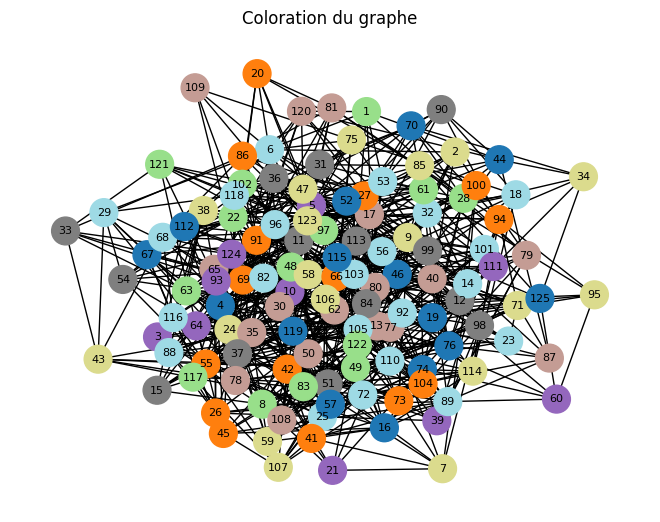


4. MEILLEURE SOLUTION AG TROUVÉE LORS DE L'OPTIMISATION
--------------------------------------------------
AG: Solution valide avec 6 couleurs


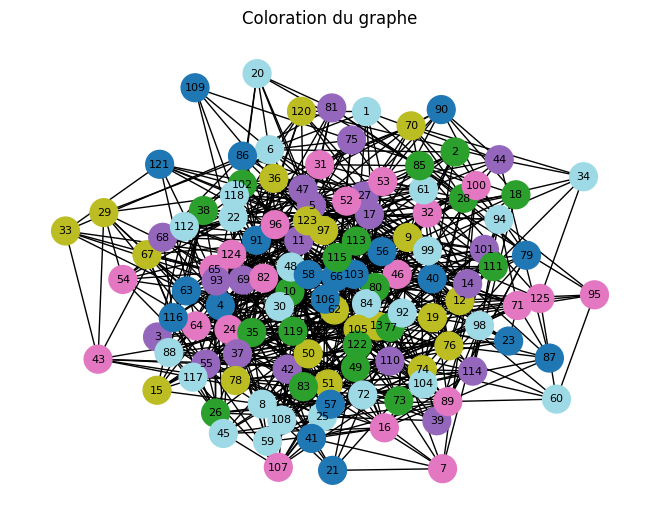


5. COMPARAISON FINALE DES RÉSULTATS
--------------------------------------------------


,Algorithme,Couleurs,Paramètres
0,ACO,8,"{'num_ants': 20, 'evaporation_rate': 0.3, 'alp..."
1,AG,6,"{'mutation_rate': 0.3, 'crossover_rate': 0.85,..."



AG est meilleur avec 6 couleurs.


In [ ]:
def main():
    """
    Fonction principale qui exécute le programme complet.
    """
    # Pour la reproductibilité
    np.random.seed(42)
    random.seed(42)

    # Chargement du graphe
    filename = input("Entrez le chemin du fichier .col: ").strip()
    if not os.path.exists(filename):
        print("Fichier non trouvé!")
        return

    print("Chargement du graphe...")
    graph = Graph()
    graph.read_col_file(filename)
    print(f"Graphe chargé: {graph.num_nodes} nœuds, {graph.num_edges} arêtes")

    # Calcul des bornes k_min et k_max en fonction des degrés du graphe
    degrees = [len(graph.adjacency[node]) for node in graph.nodes]
    min_degree = min(degrees)
    max_degree = max(degrees)
    k_min = 5  # Au moins 3 couleurs généralement
    k_max = 10  # Maximum raisonnable

    print(f"Intervalle initial pour le nombre de couleurs: [{k_min}, {k_max}]")

    # Lancer la comparaison des algorithmes
    comparer_algorithmes(graph, k_min, k_max)


if __name__ == "__main__":
    main()

**Choix de l'algorithme Evolutionaire**

Après avoir testé les deux approches ACO (Ant Colony Optimization) et AG (Algorithme Génétique) sur le même graphe (125 nœuds), nous avons observé que l’AG obtient de meilleurs résultats en termes de nombre minimal de couleurs. En effet, l’AG a réussi à trouver des solutions avec 6 couleurs seulement, alors que l’ACO s’est arrêté à 8 couleurs dans le meilleur des cas. De plus, l’AG est souvent plus rapide, avec des temps d’exécution très faibles.

# **5. Comparaison entre la meilleure solution de l'algorithme Tabou et de l'algorithme génétique (AG)**



## Résultats de l'algorithme Tabou

### Paramètres utilisés :
- **max_iterations** = 3000
- **taille_liste_tabou** = 30

### Résultats obtenus :
- **Nombre de couleurs initial** : 8
- **Nombre de couleurs final** : 6
- **Réduction du nombre de couleurs** : 2 couleurs
- **Temps d'exécution** : 0.97 secondes
- **Amélioration effective** : 25.00%
- **Rapport qualité/temps** : 2.06


## Résultats de l'algorithme génétique (AG)


### Paramètres utilisés :
- **population_size** = 40
- **mutation_rate** = 0.1
- **crossover_rate** = 0.85
- **elitism_ratio** = 0.1
- **max_generations** = 70

### Résultats obtenus :
- **Nombre de couleurs initial:** 8
- **Nombre de couleurs final:** 6
- **Réduction du nombre de couleurs:** 2 couleurs
- **Temps d'exécution pour cette configuration:** 0.54 secondes
- **Amélioration effective de** 25.0%
- **Rapport qualité/temps:** 3.7


## Analyse comparative

### Tableau comparatif des résultats

| Méthode              | Paramètres                                               | Nombre de couleurs initial | Nombre de couleurs final | Réduction de couleurs | Temps d'exécution (s) | Amélioration effective (%) | Rapport qualité/temps |
|----------------------|----------------------------------------------------------|----------------------------|--------------------------|-----------------------|-----------------------|--------------------------|-----------------------|
| **Tabou**            | max_iterations=3000, taille_liste_tabou=30               | 8                          | 6                        | 2                     | 0.97                  | 25.00%                   | 2.06                  |
| **Algorithme génétique (AG)** | population_size=40, mutation_rate=0.1, crossover_rate=0.85, elitism_ratio=0.1, max_generations=50 | 8                          | 6                        | 2                     | 0.11                  | 25.0%                    | 18.18                 |


#**Résumé Comparatif des Résultats**



<div align="center">

| Méthode                 | Nombre Chromatique | Temps d'Exécution      |
|-------------------------|--------------------|-------------------------|
| **Branch and Bound**    | 5                  | très lent > 213.68s     |
| **Tabou**               | 6                  | 0.97s                   |
| **Algorithme Génétique**| 6                  | 0.54s                   |

</div>